In [1]:
# Packages imports

# Import global libraries

import warnings
import numpy as np
import pandas as pd
import seaborn  as sns
import matplotlib.pyplot as plt

# ignore warnings
warnings.filterwarnings('ignore')

In [2]:
# Import specific libraries 

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
from sklearn import metrics
from sklearn.cluster import KMeans
import umap.umap_ as umap
from matplotlib.lines import Line2D


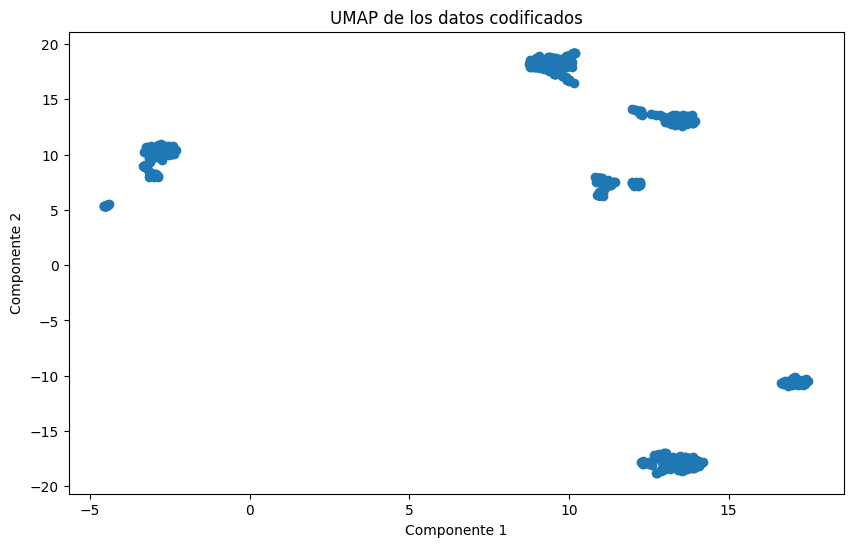

Índice de Davies-Bouldin: 0.15702847894301894
Índice de Calinski-Harabasz: 68486.80202076309
Coeficiente de Silueta: 0.86476684


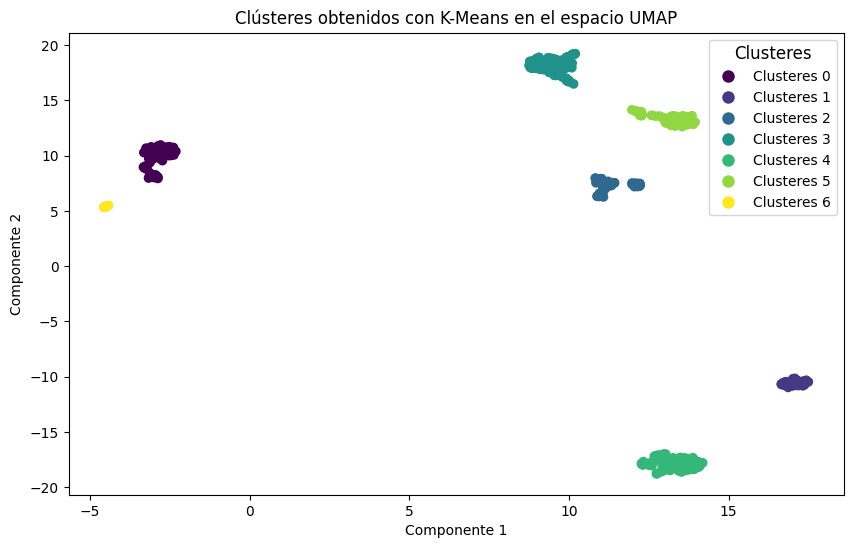

In [3]:
# Cargar el conjunto de datos
data = "C:/Users/Deme/Desktop/Master/TFM/Code/GitR/mammographic_masses_data.csv"
df = pd.read_csv(data)
df = df.dropna()

malignant_diagnosis = df['malignant']

# Select data to clustering
cluster_cols = ['age', 'shape', 'margin', 'density']
df_models = df[cluster_cols]

# Convert to categorical variables
df_models['shape'] = df_models['shape'].astype('object')
df_models['margin'] = df_models['margin'].astype('object')
df_models['density'] = df_models['density'].astype('object')

df_onehot_categorical = df_models.drop('age', axis=1).copy()

# One-hot encode categorical variables
ohe = OneHotEncoder(sparse_output = False)
encoder_categorical = ohe.fit_transform(df_onehot_categorical)
categorical_encoded = pd.DataFrame(encoder_categorical, columns=ohe.get_feature_names_out(df_onehot_categorical.columns))

# Aplicar UMAP a los datos codificados
umap_model = umap.UMAP(n_components=2, random_state = 1)
umap_components = umap_model.fit_transform(categorical_encoded)

# Visualizar los datos reducidos con UMAP
plt.figure(figsize=(10, 6))
plt.scatter(umap_components[:, 0], umap_components[:, 1])
plt.title('UMAP de los datos codificados')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.show()


# Visualizar los clusters obtenidos con K-Means

kmeans_model = KMeans(n_clusters=7, init='k-means++', random_state=42)
kmeans_clusters = kmeans_model.fit_predict(umap_components)

# Calcular el índice de Davies-Bouldin
db_index = davies_bouldin_score(umap_components, kmeans_clusters)

# Calcular el índice de Calinski-Harabasz
ch_index = calinski_harabasz_score(umap_components, kmeans_clusters)

# Calcular el coeficiente de silueta
silhouette_avg = silhouette_score(umap_components, kmeans_clusters)


# Imprimir los resultados
print("Índice de Davies-Bouldin:", db_index)
print("Índice de Calinski-Harabasz:", ch_index)
print("Coeficiente de Silueta:", silhouette_avg)


plt.figure(figsize=(10, 6))
plt.scatter(umap_components[:, 0], umap_components[:, 1], c=kmeans_clusters, cmap='viridis')
plt.title('Clústeres obtenidos con K-Means en el espacio UMAP')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Clusteres {i}', 
                          markerfacecolor=plt.cm.viridis(i / max(kmeans_clusters)), markersize=10)
                   for i in range(max(kmeans_clusters) + 1)]
plt.legend(handles=legend_elements, title='Clusteres', loc='best', fontsize='medium', title_fontsize='large')
plt.show()

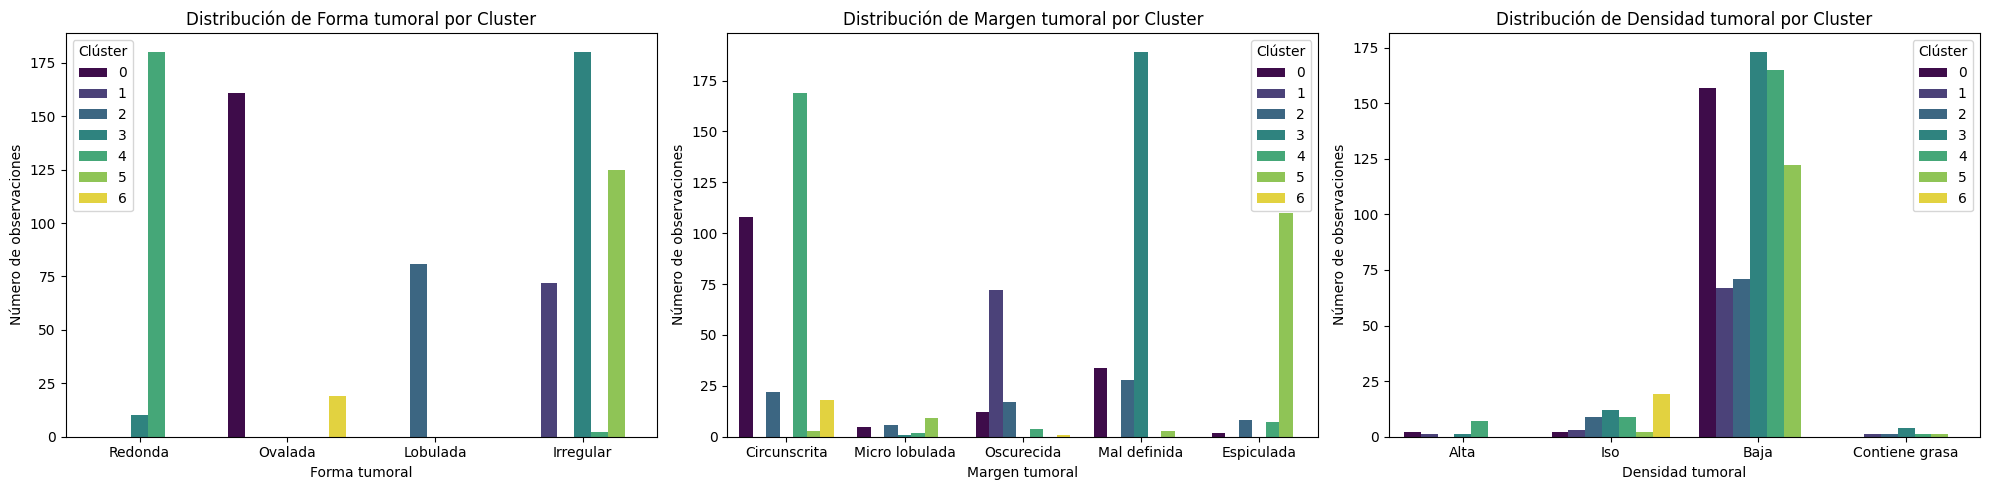

In [9]:
df_kmeans_eval = df_models.copy()

df_kmeans_eval['Cluster'] = kmeans_clusters
# Add diagnosis variable to evaluation dataframe
df_kmeans_eval['Malignant'] = malignant_diagnosis

# Mapeos de las categorías
shape_mapping = {1: 'Redonda', 2: 'Ovalada', 3: 'Lobulada', 4: 'Irregular'}
margin_mapping = {1: 'Circunscrita', 2: 'Micro lobulada', 3: 'Oscurecida', 4: 'Mal definida', 5: 'Espiculada'}
density_mapping = {1: 'Alta', 2: 'Iso', 3: 'Baja', 4: 'Contiene grasa'}

# Función auxiliar para mapear etiquetas
def map_labels(labels, mapping):
    mapped_labels = []
    for label in labels:
        try:
            int_label = int(float(label.get_text()))  # Convertir a float primero y luego a int
            mapped_labels.append(mapping.get(int_label, label.get_text()))
        except ValueError:
            mapped_labels.append(label.get_text())  # Mantener la etiqueta original si no se puede convertir
    return mapped_labels

# Figuras y ejes para los subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Distribución de 'Shape' por cluster
sns.countplot(x='shape', hue='Cluster', data=df_kmeans_eval, palette='viridis', ax=axs[0])
axs[0].set_title('Distribución de Forma tumoral por Cluster')
axs[0].set_xlabel('Forma tumoral')
axs[0].set_ylabel('Número de observaciones')
axs[0].legend(title='Clúster')
axs[0].set_xticklabels(map_labels(axs[0].get_xticklabels(), shape_mapping))

# Distribución de 'Margin' por cluster
sns.countplot(x='margin', hue='Cluster', data=df_kmeans_eval, palette='viridis', ax=axs[1])
axs[1].set_title('Distribución de Margen tumoral por Cluster')
axs[1].set_xlabel('Margen tumoral')
axs[1].set_ylabel('Número de observaciones')
axs[1].legend(title='Clúster')
axs[1].set_xticklabels(map_labels(axs[1].get_xticklabels(), margin_mapping))

# Distribución de 'Density' por cluster
sns.countplot(x='density', hue='Cluster', data=df_kmeans_eval, palette='viridis', ax=axs[2])
axs[2].set_title('Distribución de Densidad tumoral por Cluster')
axs[2].set_xlabel('Densidad tumoral')
axs[2].set_ylabel('Número de observaciones')
axs[2].legend(title='Clúster')
axs[2].set_xticklabels(map_labels(axs[2].get_xticklabels(), density_mapping))

# Ajustar los subplots
plt.tight_layout()

# Mostrar los gráficos
plt.show()

Malignant counts by cluster:
Malignant  False  True 
Cluster                
0            130     31
1             16     56
2             39     42
3             43    147
4            156     26
5             24    101
6             19      0
Proporciones de casos malignos por cluster:
Cluster
0    0.192547
1    0.777778
2    0.518519
3    0.773684
4    0.142857
5    0.808000
6    0.000000
Name: Malignant, dtype: float64


<Figure size 1000x600 with 0 Axes>

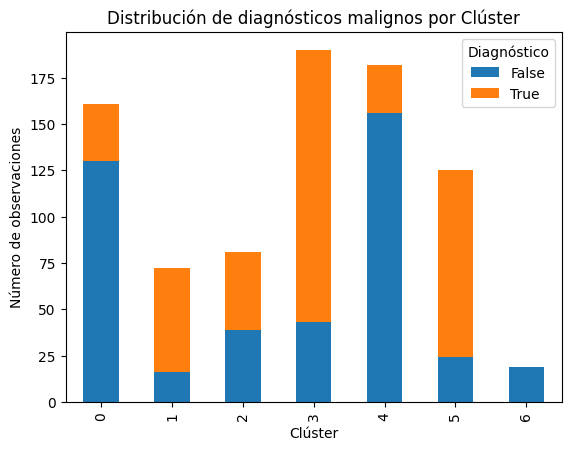

In [7]:
# Count the number of malignant diagnosis by cluster
print("Malignant counts by cluster:")
print(df_kmeans_eval.groupby(['Cluster', 'Malignant']).size().unstack(fill_value=0))

# Group by cluster number and calculate the proportion of malignant cases in each cluster.
malignant_proportions = df_kmeans_eval.groupby('Cluster')['Malignant'].mean()

# Show the proportions of malignant cases by cluster.
print("Proporciones de casos malignos por cluster:")
print(malignant_proportions)

# Histogram of malignant diagnoses per cluster
plt.figure(figsize=(10, 6))
df_kmeans_eval.groupby(['Cluster', 'Malignant']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Distribución de diagnósticos malignos por Clúster')
plt.xlabel('Clúster')
plt.ylabel('Número de observaciones')
plt.legend(title='Diagnóstico')
plt.show()

In [8]:
import pickle

pickle.dump(kmeans_model, open("kmeans_model.pkl", "wb"))
pickle.dump(umap_model, open("umap_model.pkl", "wb"))
pickle.dump(ohe, open("ohe.pkl", "wb"))